# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - Learning rate Scheduler 활용
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
- 배치/ Epoch
    - batch size: 64
    - Epoch: 100
    - EarlyStopping 적용
      - 사용자 정의 모듈
      - https://github.com/Bjarten/early-stopping-pytorch

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스

class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 128,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 128,shuffle = False,drop_last = False)
    
    return dataloaders

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 ResNet50 모델 호출 -> head 부분 수정
def build_resnet50_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = models.resnet50(pretrained = True) # 이미 학습된 resnet50 모델 불러오기
    
    # 일반 NN layer(FC layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1))
    model.fc = nn.Linear(2048,7) # 7개의 감정으로 분류
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 30 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_resnet50_based_model()
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-1,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.1,
                                                       min_lr = 1e-10,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 20, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Best Accuracy: {best_acc}')

0/227 - Running loss: 1.953687310218811
30/227 - Running loss: 2.1503682136535645
60/227 - Running loss: 2.2431070804595947
90/227 - Running loss: 2.112880229949951
120/227 - Running loss: 1.8811349868774414
150/227 - Running loss: 1.8428064584732056
180/227 - Running loss: 1.8742830753326416
210/227 - Running loss: 1.9100849628448486
1/100-Train Loss:2.2376086738141097, Val Loss:1.8845940047296985
1/100-Train Acc:0.2385737885462555, Val Acc:0.2416487068965517
0/227 - Running loss: 1.9568346738815308
30/227 - Running loss: 1.8340586423873901
60/227 - Running loss: 1.81892991065979
90/227 - Running loss: 1.7852373123168945
120/227 - Running loss: 1.8981943130493164
150/227 - Running loss: 1.7937219142913818
180/227 - Running loss: 1.748677134513855
210/227 - Running loss: 1.8259693384170532
2/100-Train Loss:1.8442988542733214, Val Loss:1.8514429084185897
2/100-Train Acc:0.24741877753303965, Val Acc:0.24245689655172414
0/227 - Running loss: 1.8568127155303955
30/227 - Running loss: 1.827

180/227 - Running loss: 1.460722804069519
210/227 - Running loss: 1.3827462196350098
EarlyStopping counter: 1 out of 20
18/100-Train Loss:1.4151369627351802, Val Loss:1.4132068691582516
18/100-Train Acc:0.4658934471365639, Val Acc:0.4551294929865576
0/227 - Running loss: 1.4451559782028198
30/227 - Running loss: 1.3979843854904175
60/227 - Running loss: 1.4205902814865112
90/227 - Running loss: 1.5265825986862183
120/227 - Running loss: 1.3983594179153442
150/227 - Running loss: 1.370177149772644
180/227 - Running loss: 1.3503421545028687
210/227 - Running loss: 1.359331488609314
19/100-Train Loss:1.3968717925874148, Val Loss:1.3745036659569576
19/100-Train Acc:0.4777670704845815, Val Acc:0.47085037989479833
0/227 - Running loss: 1.3399087190628052
30/227 - Running loss: 1.3339393138885498
60/227 - Running loss: 1.4387928247451782
90/227 - Running loss: 1.5134778022766113
120/227 - Running loss: 1.317516803741455
150/227 - Running loss: 1.2995604276657104
180/227 - Running loss: 1.3444

210/227 - Running loss: 1.1782057285308838
EarlyStopping counter: 1 out of 20
35/100-Train Loss:1.0989359527957596, Val Loss:1.2028686198694953
35/100-Train Acc:0.6130919603524229, Val Acc:0.5465919053185272
0/227 - Running loss: 1.1121340990066528
30/227 - Running loss: 1.115666389465332
60/227 - Running loss: 1.1491678953170776
90/227 - Running loss: 1.137876272201538
120/227 - Running loss: 1.2000571489334106
150/227 - Running loss: 0.8701291084289551
180/227 - Running loss: 1.047585368156433
210/227 - Running loss: 1.1276304721832275
36/100-Train Loss:1.0881964057552658, Val Loss:1.1765163520286823
36/100-Train Acc:0.6183232378854625, Val Acc:0.55916678842782
0/227 - Running loss: 1.026484727859497
30/227 - Running loss: 1.004486083984375
60/227 - Running loss: 1.1777552366256714
90/227 - Running loss: 1.1064859628677368
120/227 - Running loss: 0.9229486584663391
150/227 - Running loss: 1.1978856325149536
180/227 - Running loss: 1.0469914674758911
210/227 - Running loss: 1.25693488

30/227 - Running loss: 0.7552051544189453
60/227 - Running loss: 0.7011295557022095
90/227 - Running loss: 0.7275295257568359
120/227 - Running loss: 0.8574187159538269
150/227 - Running loss: 0.840906023979187
180/227 - Running loss: 0.7936455607414246
210/227 - Running loss: 0.8161057233810425
EarlyStopping counter: 7 out of 20
52/100-Train Loss:0.7216593499750817, Val Loss:1.1715136971966973
52/100-Train Acc:0.7382640418502202, Val Acc:0.5964348334307423
0/227 - Running loss: 0.7473329901695251
30/227 - Running loss: 0.7318382263183594
60/227 - Running loss: 0.7058829665184021
90/227 - Running loss: 0.7585174441337585
120/227 - Running loss: 0.7134700417518616
150/227 - Running loss: 0.8425750732421875
180/227 - Running loss: 0.6992062330245972
210/227 - Running loss: 0.6471824049949646
Epoch 00053: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 8 out of 20
53/100-Train Loss:0.7233074359956817, Val Loss:1.1816454879168807
53/100-Train Acc:0.7379887114537445,

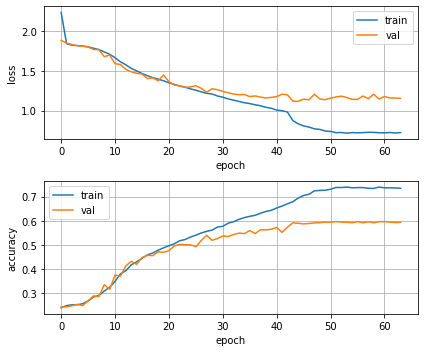

In [16]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()